In [1]:
# Nativos
import random as rn
import os
import sys
import gc

#calculo
import numpy as np
import pandas as pd
import scipy

import pandas as pd
import scorecardpy as sc

SEED = 29082013
os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
rn.seed(SEED)

### Utilitarios

In [2]:
def calcular_pesos(modelo):
    coef_model = pd.DataFrame(modelo.tvalues, columns=['t_value'])
    coef_model['t_value2'] = np.power(coef_model['t_value'],2)
    coef_model['total'] = sum(coef_model['t_value2'])
    coef_model['part'] = coef_model['t_value2'] / coef_model['total']
    coef_model['pesos'] = coef_model['part'] * 100
    return coef_model['pesos'].sort_values(ascending=True)

In [3]:
x_train = pd.read_csv("X_train.csv")
x_valid = pd.read_csv("X_valid.csv")

y_train = pd.read_csv("y_train.csv")
y_valid = pd.read_csv("y_valid.csv")

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((51120, 60), (12781, 60), (51120, 1), (12781, 1))

### >> Modleo mayor p-value

In [4]:
cols_aporte = [
 'Empleado',
 'Saldo_cuenta',
 'Valor_prestamo',
 'Autocontrol',
 'Impulsividad',
 'Confianza' 
]

In [5]:
x_train['target'] = y_train.values
matriz_corr = x_train[cols_aporte + ['target']].corr(method='pearson')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Saldo_cuenta,Valor_prestamo,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.00228,-0.00777,0.00654,-0.00507,0.00307,-0.00068
Saldo_cuenta,0.00228,1.00000,-0.00130,-0.00113,0.00471,-0.00429,-0.00690
Valor_prestamo,-0.00777,-0.00130,1.00000,0.00992,-0.00262,0.00102,-0.00211
Autocontrol,0.00654,-0.00113,0.00992,1.00000,0.00412,0.00735,-0.00478
Impulsividad,-0.00507,0.00471,-0.00262,0.00412,1.00000,-0.00452,-0.00201
Confianza,0.00307,-0.00429,0.00102,0.00735,-0.00452,1.00000,0.00093
target,-0.00068,-0.00690,-0.00211,-0.00478,-0.00201,0.00093,1.00000


In [6]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00690
Autocontrol,0.00478
Valor_prestamo,0.00211
Impulsividad,0.00201
Confianza,0.00093
Empleado,0.00068


In [7]:
matriz_corr = x_train[cols_aporte + ['target']].corr(method='spearman')

matriz_corr.style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,Empleado,Saldo_cuenta,Valor_prestamo,Autocontrol,Impulsividad,Confianza,target
Empleado,1.00000,0.00248,-0.00547,0.00558,-0.00528,0.00263,-0.00068
Saldo_cuenta,0.00248,1.00000,0.00325,-0.00083,0.00214,-0.00655,-0.00791
Valor_prestamo,-0.00547,0.00325,1.00000,0.00950,-0.00224,0.00085,-0.00436
Autocontrol,0.00558,-0.00083,0.00950,1.00000,0.00415,0.00759,-0.00407
Impulsividad,-0.00528,0.00214,-0.00224,0.00415,1.00000,-0.00383,-0.00219
Confianza,0.00263,-0.00655,0.00085,0.00759,-0.00383,1.00000,0.00042
target,-0.00068,-0.00791,-0.00436,-0.00407,-0.00219,0.00042,1.00000


In [8]:
pd.DataFrame(matriz_corr['target'].abs().sort_values(ascending=False)).style.background_gradient(
    cmap='coolwarm', axis=None
).set_precision(5)

,target
target,1.00000
Saldo_cuenta,0.00791
Valor_prestamo,0.00436
Autocontrol,0.00407
Impulsividad,0.00219
Empleado,0.00068
Confianza,0.00042


In [9]:
if 'target' in x_train.columns:
    del x_train['target']

In [10]:
y_train.value_counts(normalize=True)

Incumplimiento
0                 0.858842
1                 0.141158
dtype: float64

In [11]:
len(x_train[cols_aporte].columns)

6

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

kfold_off_on = RepeatedStratifiedKFold(
    n_splits=3, 
    n_repeats=2,
    random_state=SEED
)

param_grid_arbol = {
    'penalty': ['elasticnet', 'none'],
    'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],             
    'n_jobs': 4,
    'max_iter': [50, 25, 75, 35],
    'solver': ['liblinear', 'saga', 'sag'],
    'random_state': [SEED],
    'class_weight': ['balanced', None],
    'fit_intercept': [True, False],
    'C': [1, 10, 20, 50]
}
model_arbol = LogisticRegression(random_state=SEED)

grid_arbol = RandomizedSearchCV(
    model_arbol, 
    {k: [v] if not isinstance(v, list) else v for k, v in param_grid_arbol.items()}, 
    cv=kfold_off_on, 
    n_jobs=4, 
    scoring='roc_auc', 
    verbose=2,
    n_iter=1000,
    refit=True
)

In [13]:
#help(grid_arbol.fit)

In [14]:
%%time
grid_arbol.fit(
    x_train[cols_aporte],
    y_train,
)

best_params_arbol = grid_arbol.best_params_
score_arbol = grid_arbol.best_score_
result_2 = grid_arbol.best_estimator_

print("score: ", score_arbol)

Fitting 6 folds for each of 1000 candidates, totalling 6000 fits


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.50382342 0.49627557        nan 0.49827193 0.49794532 0.49634824
 0.49692876        nan 0.49804855 0.49804855 0.4980521         nan
        nan        nan 0.49827193        nan        nan 0.49807261
        nan        nan 0.4980521  0.49805239 0.49637248 0.4980521
 0.49637248        nan        nan        nan        nan        nan
 0.50382347        nan 0.49697771 0.49623742        nan        nan
 0.49808091 0.49636276        nan 0.49816025 0.4980521         nan
        nan 0.4980521  0.4963741         nan 0.49812636 0.49816025
        nan        nan 0.50382347 0.49873554        nan        nan
        nan        nan        nan        nan 0.50369821 0.50382347
        nan 0.49804855        nan 0.49805239 0.49804855        nan
        nan 0.49636276 0.49627353        nan        nan 0.49804855
        nan        nan        nan        nan 0.5038234

score:  0.5038238516658299
Wall time: 7min 45s


In [15]:
best_params_arbol

{'solver': 'sag',
 'random_state': 29082013,
 'penalty': 'none',
 'n_jobs': 4,
 'max_iter': 35,
 'l1_ratio': 0.2,
 'fit_intercept': False,
 'class_weight': None,
 'C': 1}

In [16]:
import numpy as np
#prediciendo en base al modelo 
y_pred_prob_2_train = result_2.predict_proba(x_train[cols_aporte])[:,1]
y_pred_class_2_train = np.where(y_pred_prob_2_train < 0.5, 0 , 1)

y_pred_prob_2_valid = result_2.predict_proba(x_valid[cols_aporte])[:,1]
y_pred_class_2_valid = np.where(y_pred_prob_2_valid < 0.5, 0 , 1)

In [17]:
pd.Series(y_pred_class_2_train).value_counts()

0    51120
dtype: int64

In [18]:
pd.Series(y_pred_class_2_valid).value_counts()

0    12781
dtype: int64

<AxesSubplot:>

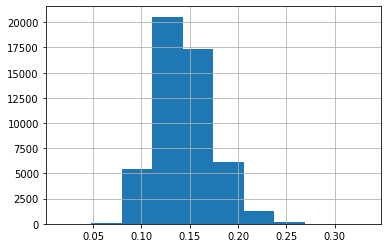

In [19]:
pd.Series(y_pred_prob_2_train).hist()

<AxesSubplot:>

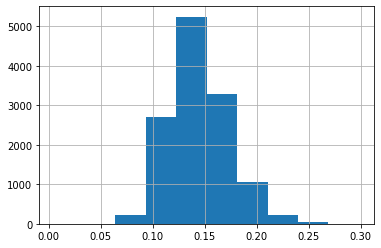

In [20]:
pd.Series(y_pred_prob_2_valid).hist()

In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

print("/"*25, 'TRAIN')
auc = roc_auc_score(y_train, y_pred_prob_2_train)
print("AUC: %1.3f" % auc)
print("GINI: %1.3f" % (2*auc-1))

print("/"*25, 'VALIDATION')
auc_2 = roc_auc_score(y_valid, y_pred_prob_2_valid)
print("AUC: %1.3f" % auc_2)
print("GINI: %1.3f" % (2*auc_2-1))

///////////////////////// TRAIN
AUC: 0.505
GINI: 0.009
///////////////////////// VALIDATION
AUC: 0.510
GINI: 0.021


In [22]:
print("/"*25, 'TRAIN')
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_2_train))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_2_train))
print("F1 SCORE   : %1.8f" % accuracy_score(y_train, y_pred_class_2_train))

print("/"*25, 'VALIDATION')
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_2_valid))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_2_valid))
print("F1 SCORE   : %1.8f" % accuracy_score(y_valid, y_pred_class_2_valid))

///////////////////////// TRAIN
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
F1 SCORE   : 0.85884194
///////////////////////// VALIDATION
RECALL     : 0.00000000
EFECTIVIDAD: 0.00000000
F1 SCORE   : 0.00000000
F1 SCORE   : 0.85885298


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### >>> RECALL

In [23]:
from scipy.optimize import differential_evolution


optimization_rec = differential_evolution(
    lambda c: -1*recall_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_rec

     fun: -1.0
 message: 'Optimization terminated successfully.'
    nfev: 122
     nit: 7
 success: True
       x: array([0.01298791])

In [24]:
corte_rec = optimization_rec['x'][0]
corte_rec

0.012987907660010789

In [25]:
y_pred_class_train_2_rec = np.where(y_pred_prob_2_train < corte_rec, 0 , 1)
y_pred_class_valid_2_rc = np.where(y_pred_prob_2_valid < corte_rec, 0 , 1)

In [26]:
pd.Series(y_pred_class_train_2_rec).value_counts()

1    51120
dtype: int64

In [27]:
pd.Series(y_pred_class_valid_2_rc).value_counts()

1    12780
0        1
dtype: int64

In [28]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_rec))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_rec))
print("F1 SCORE   : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_rec))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_rc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_rc))
print("F1 SCORE   : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_rc))

///////////////////////// TRAIN
RECALL     : 1.00000000
EFECTIVIDAD: 0.14115806
F1 SCORE   : 0.24739440
F1 SCORE   : 0.14115806
///////////////////////// VALIDATION
RECALL     : 1.00000000
EFECTIVIDAD: 0.14115806
F1 SCORE   : 0.24739440
F1 SCORE   : 0.14122526


#### >>> EFECTIVIDAD

In [29]:
optimization_pre = differential_evolution(
    lambda c: -1*precision_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=SEED
)
optimization_pre

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision 

     fun: -0.3333333333333333
 message: 'Optimization terminated successfully.'
    nfev: 167
     nit: 10
 success: True
       x: array([0.28896121])

#### >>> AUC

In [30]:
optimization_auc = differential_evolution(
    lambda c: -1*roc_auc_score(y_train, np.array([0 if _ < c[0] else 1 for _ in y_pred_prob_2_train])), 
    [(0, 1)],
    seed=123
)
optimization_auc

     fun: -0.504076521723672
 message: 'Optimization terminated successfully.'
    nfev: 32
     nit: 1
 success: True
       x: array([0.14845676])

In [31]:
corte_auc = optimization_auc['x'][0]
corte_auc

0.14845676357094684

In [32]:
y_pred_class_train_2_auc = np.where(y_pred_prob_2_train < corte_auc, 0 , 1)
y_pred_class_valid_2_auc = np.where(y_pred_prob_2_valid < corte_auc, 0 , 1)

In [33]:
pd.Series(y_pred_class_train_2_auc).value_counts()

0    30126
1    20994
dtype: int64

In [34]:
pd.Series(y_pred_class_valid_2_auc).value_counts()

0    7536
1    5245
dtype: int64

In [35]:
print("/"*25, "TRAIN")
print("RECALL     : %1.8f" % recall_score(y_train, y_pred_class_train_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_train, y_pred_class_train_2_auc))
print("F1 SCORE   : %1.8f" % accuracy_score(y_train, y_pred_class_train_2_auc))

print("/"*25, "VALIDATION")
print("RECALL     : %1.8f" % recall_score(y_valid, y_pred_class_valid_2_auc))
print("EFECTIVIDAD: %1.8f" % precision_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % f1_score(y_valid, y_pred_class_valid_2_auc))
print("F1 SCORE   : %1.8f" % accuracy_score(y_valid, y_pred_class_valid_2_auc))

///////////////////////// TRAIN
RECALL     : 0.41768293
EFECTIVIDAD: 0.14356483
F1 SCORE   : 0.21368309
F1 SCORE   : 0.56607981
///////////////////////// VALIDATION
RECALL     : 0.41851441
EFECTIVIDAD: 0.14394662
F1 SCORE   : 0.21421478
F1 SCORE   : 0.56662233
